In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np

In [151]:
from toolkit import trappist1, transit_model, trappist_out_of_transit, trappist1_all_transits
from copy import deepcopy

g = trappist1('g')
original_g = deepcopy(g)

In [152]:
from glob import glob
lc_paths = sorted(glob('all_transits/phot*'))
midtransit_times = len(lc_paths) * [g.t0]

-0.0363843101077


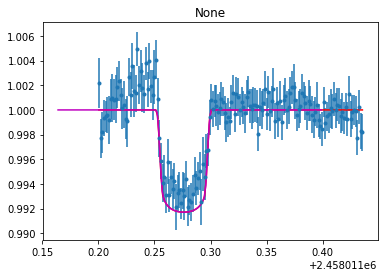

-0.000309438910335


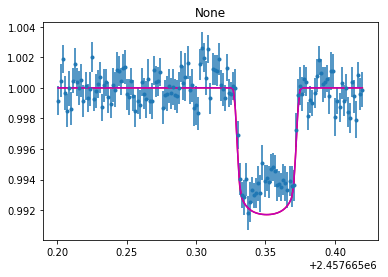

0.0014680842869


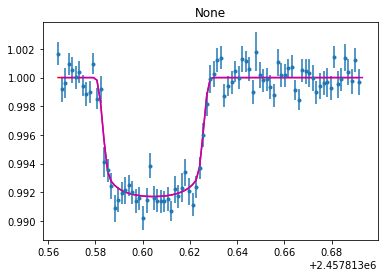

0.00126112811267


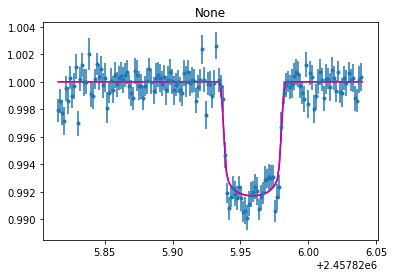

-0.0074220020324


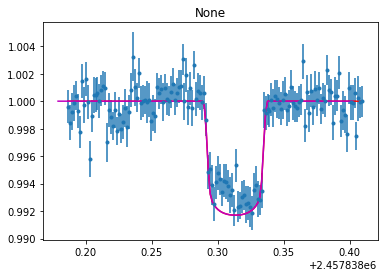

In [155]:
original_t0 = deepcopy(g.t0)
all_times = []
midtransit_time_offsets = []
for i, path, midtransit_time in zip(np.arange(len(lc_paths)), lc_paths, midtransit_times):

    for j in range(2):
        bjd, flux, err, x, y, fwhm, fwhmx, fwhmy, bg, airmass, exptime = np.loadtxt(path, unpack=True)
        all_times.append(bjd)
        bjd += 2450000

        if j == 1: 
            g.t0 = midtransit_times[i]
            
        transit_model_g = transit_model(bjd, g)
        all_transits = trappist1_all_transits(bjd)

        oot = all_transits == 1

        X_all = np.vstack([x, y, fwhmx, fwhmy]).T

        X = X_all[oot, :]

        omega = np.diag(err[oot]**2)
        omega_inv = np.linalg.inv(omega)

        V = np.linalg.inv(X.T @ omega_inv @ X)
        beta = V @ X.T @ omega_inv @ flux[oot]

        regressed_lc = flux - (X_all @ beta) + 1
        regressed_lc /= np.median(regressed_lc[oot])

        from scipy.optimize import fmin_powell, fmin_l_bfgs_b

        def minimize_this(p):
            return abs(np.sum((regressed_lc[oot] - transit_model_g[oot])**2 / 
                              (p[0] * err[oot])**2)/len(regressed_lc[oot]) - 1)

        err_scale = fmin_powell(minimize_this, [1], disp=False)
        err *= err_scale


        def transit_model_t(p):
            params = deepcopy(g)
            params.t0 = p[0]
            return transit_model(bjd, params)

        def chi2(p):
            return np.sum((regressed_lc - transit_model_t(p))**2 / err**2)

        #result = fmin_powell(chi2, [bjd[np.argmin(regressed_lc)]], disp=False)
        #result = fmin_powell(chi2, [midtransit_time], disp=False)
        result = fmin_l_bfgs_b(chi2, [bjd[np.argmin(regressed_lc)]], approx_grad=True, 
                               bounds=[(bjd.min(), bjd.max())])[0]
        if j == 0: 
            midtransit_times[i] = result[0]
            
    n_transits = np.round((bjd.mean() - original_g.t0) / g.per)
    midtransit_time_offset = midtransit_times[i] - (original_g.t0 + n_transits*g.per)
    print(midtransit_time_offset)
    midtransit_time_offsets.append(midtransit_time_offset)
    plt.errorbar(bjd - midtransit_time_offset, regressed_lc, err, fmt='.')
    
    np.savetxt('reduced_lcs/lightcurve_{}.txt'.format(i), np.vstack([bjd - midtransit_time_offset, regressed_lc, err]).T)
    plt.plot(bjd - midtransit_time_offset, transit_model_t(result), 'r')

    plt.plot(bjd, transit_model(bjd, original_g), 'm')

#     plt.plot(bjd, all_transits)
    plt.title(note)
    
    plt.show()

In [108]:
all_lcs = np.vstack(sorted([np.loadtxt(i) for i in glob('reduced_lcs/lightcurve_?.txt')], key=lambda x: x[0][0]))
np.savetxt('reduced_lcs/all_lightcurves.txt', all_lcs)

In [100]:
all_lcs[:, 0].min(), all_lcs[:, 0].ptp(), 

(2457665.2009626743, 346.23463246878237)

In [179]:
import os
import shutil
from subprocess import Popen

lc_paths = glob('reduced_lcs/lightcurve_?.txt')
for i in range(len(lc_paths)):
    new_dir = "stsp_{0:d}".format(i)
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
    
    shutil.copy('stsp/g.in', os.path.join(new_dir, '.'))
    shutil.copy('stsp/stsp_20180302', os.path.join(new_dir, '.'))
    shutil.copy(lc_paths[i], os.path.join(new_dir, '.'))
    
    bjd, flux, err = np.loadtxt(lc_paths[i], unpack=True)
    original_infile = open(os.path.join(new_dir, 'g.in')).read()
    new_infile = original_infile.replace('lightcurve.txt', os.path.basename(lc_paths[i])) # Replace start time
    new_infile = new_infile.replace('2457665.2007372407', str(bjd.min())) # Replace start time
    new_infile = new_infile.replace('0.21868119994178414', str(bjd.ptp())) # Replace duration
    with open(os.path.join(new_dir, 'g.in'), 'w') as w: 
        w.write(new_infile)
    
    new_infile = new_infile.replace('1\t\t\t\t; number of spots', '0\t\t\t\t; number of spots')
    new_infile = '\n'.join(new_infile.splitlines()[:-6] + ['l', '1'])
    
    with open(os.path.join(new_dir, 'g_nospot.in'), 'w') as w: 
        w.write(new_infile)
    
    #Popen(['./stsp_20180302', 'g.in'], cwd=os.path.abspath(new_dir))
    Popen(['./stsp_20180302', 'g_nospot.in'], cwd=os.path.abspath(new_dir))

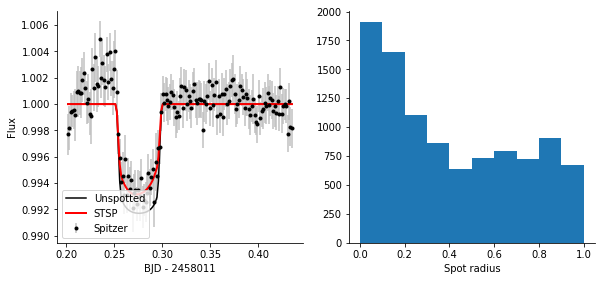

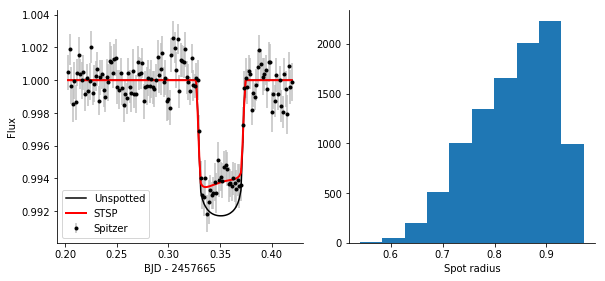

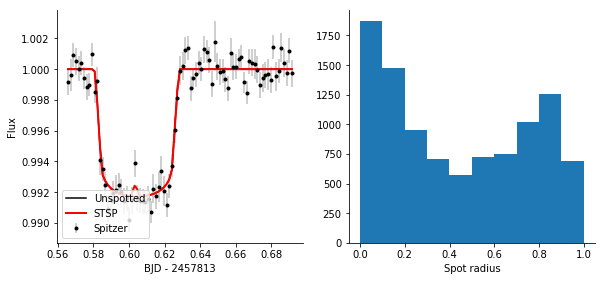

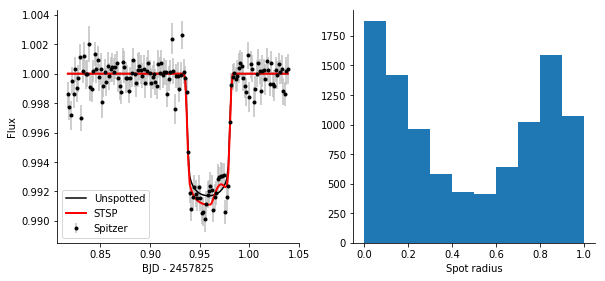

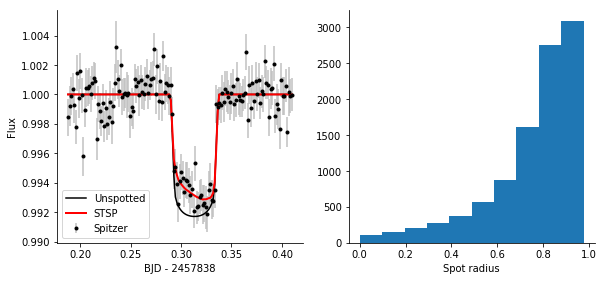

In [190]:
for i, toffset in enumerate(midtransit_time_offsets):
    new_dir = "stsp_{0:d}".format(i)
    
    bjd, flux, err, model, spotinds = np.loadtxt(os.path.join(new_dir, 'g_lcbest.txt'), unpack=True)

    bjd_model, _, _, transit_model_g, _ = np.loadtxt(os.path.join(new_dir, 'g_nospot_lcout.txt'), unpack=True)
    bjd_int = int(bjd.min())

    fig, ax = plt.subplots(1, 2, figsize=(8.5, 4))
    ax[0].errorbar(bjd - bjd_int, flux, err, fmt='.', color='k', ecolor='silver', label='Spitzer')
    ax[0].plot(bjd_model - bjd_int, transit_model_g, color='k', label='Unspotted')
    ax[0].plot(bjd - bjd_int, model, color='r', lw=2, label='STSP')

    ax[0].set(xlabel='BJD - {}'.format(bjd_int), ylabel='Flux')
    ax[0].legend(loc='lower left')

    mcmc = np.loadtxt(os.path.join(new_dir, 'g_mcmc.txt'))

    n = 10000
    radius = mcmc[-n:, 4]
    theta = mcmc[-n:, 5]
    phi = mcmc[-n:, 6]
    
    ax[1].hist(radius)
    ax[1].set_xlabel('Spot radius')
    
#     ax[1].errorbar(bjd - bjd_int, flux - transit_model_g, err, fmt='.', color='k', ecolor='silver', label='Spitzer')
#     ax[1].plot(bjd - bjd_int, model - transit_model_g, lw=2, color='r', label='STSP')
#     ax[1].set(xlabel='BJD - {}'.format(bjd_int), ylabel='Residuals')
#     ax[1].legend(loc='upper left')
    fig.tight_layout()

    for axis in ax: 
        for i in ['right', 'top']:
            axis.spines[i].set_visible(False)
    fig.savefig('stsp_model_{0}.pdf'.format(i), bbox_inches='tight', dpi=200)

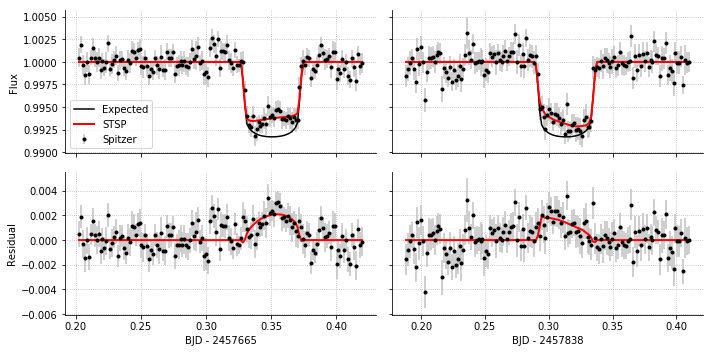

In [214]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharey='row', sharex='col')

dirs = ['stsp_1', 'stsp_4']
for i, new_dir in enumerate(dirs):
    bjd, flux, err, model, spotinds = np.loadtxt(os.path.join(new_dir, 'g_lcbest.txt'), unpack=True)

    bjd_model, _, _, transit_model_g, _ = np.loadtxt(os.path.join(new_dir, 'g_nospot_lcout.txt'), unpack=True)
    bjd_int = int(bjd.min())

    ax[0, i].errorbar(bjd - bjd_int, flux, err, fmt='.', color='k', ecolor='silver', label='Spitzer')
    ax[0, i].plot(bjd_model - bjd_int, transit_model_g, color='k', label='Expected')
    ax[0, i].plot(bjd - bjd_int, model, color='r', lw=2, label='STSP')
    
    ax[1, i].errorbar(bjd - bjd_int, flux - transit_model_g, err, fmt='.', color='k', ecolor='silver', label='Spitzer')
    ax[1, i].plot(bjd - bjd_int, model - transit_model_g, color='r', lw=2, label='STSP')
    ax[1, i].set(xlabel='BJD - {}'.format(bjd_int))

    
for axis in fig.axes: 
    for j in ['top', 'right']:
        axis.spines[j].set_visible(False)
    axis.grid(ls=':')
ax[0, 0].set_ylabel('Flux')

ax[1, 0].set_ylabel('Residual')

ax[0, 0].legend(loc='lower left')
fig.tight_layout()
fig.savefig('spot_occultations.pdf', bbox_inches='tight')